# TP2: Regresión del valor de valor medio de casas en distritos de California

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge

sns.set_theme()

In [2]:
X, y = fetch_california_housing(as_frame=True, return_X_y=True)

# shapes
X.shape, y.shape

((20640, 8), (20640,))

In [3]:
# juntamos todo
df = pd.concat((X,y),axis=1)
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


# 1) Correlación entre variables

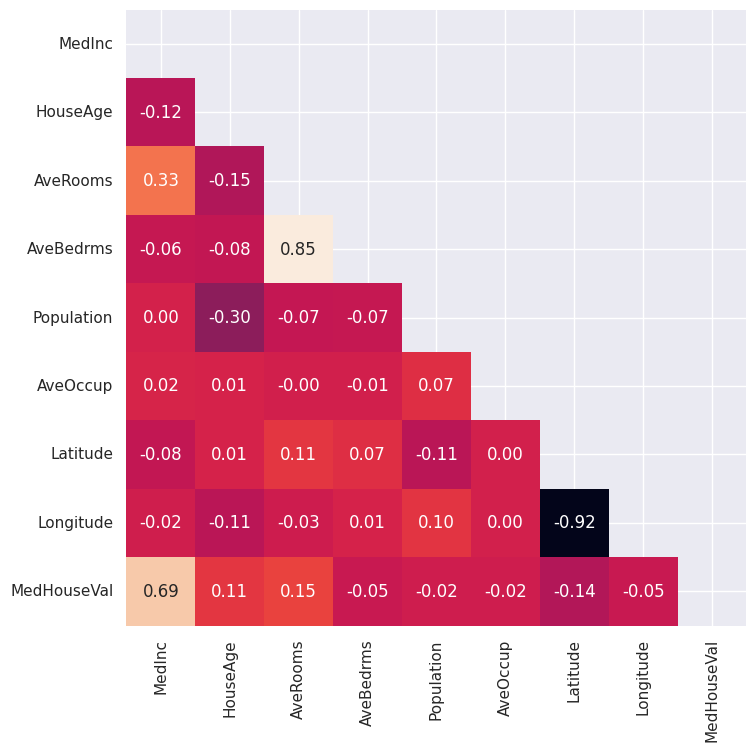

In [4]:
# matriz de correlaciones (ro de Pearson)
corr = df.corr()

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(corr, mask=np.triu(corr), 
            annot=True, fmt='.2f',
            ax=ax, cbar=False)
plt.show()

* En general las variables están poco correlacionadas, aunque eso no significa que no haya dependencia entre ellas.
* El _Median Income_ es, por lejos, el atributo con mayor correlación con la variable target de _Median House Value_.
* Algunos otros como _House Age_, _Average Rooms_ y _Latitude_ tienen una correlación con valor absoluto alrededor de 0.1.
* Algunas variables están altamente correlacionadas, como son los pares (Latitud, Longitud) y (_Average Bedrooms_, _Average Rooms_). El segundo es muy fácil de explicar, mientras que el primero requiere un gráfico de la geografía del lugar como el que se presenta más abajo.
* Existen algunos otros pares con correlaciones menores (alrededor de 0.3 en módulo) los cuales son (_Average Bedrooms_, _Median Income_) y (_Population_, _House Age_).

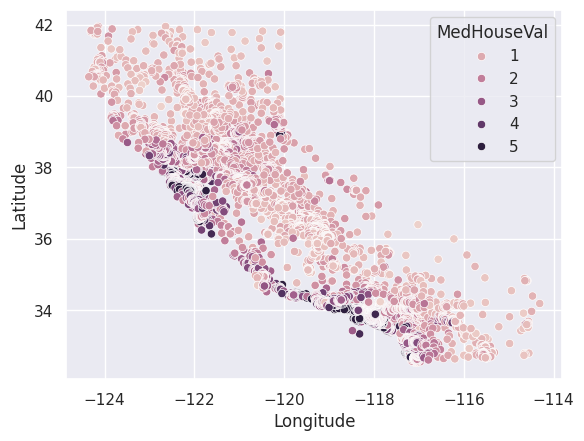

In [5]:
sns.scatterplot(df, x='Longitude', y='Latitude', hue='MedHouseVal')
plt.show()

Como se puede apreciar, la geografía del lugar hace que los valores de longitud y latitud tengan correlación negativa.

# 2) Histogramas

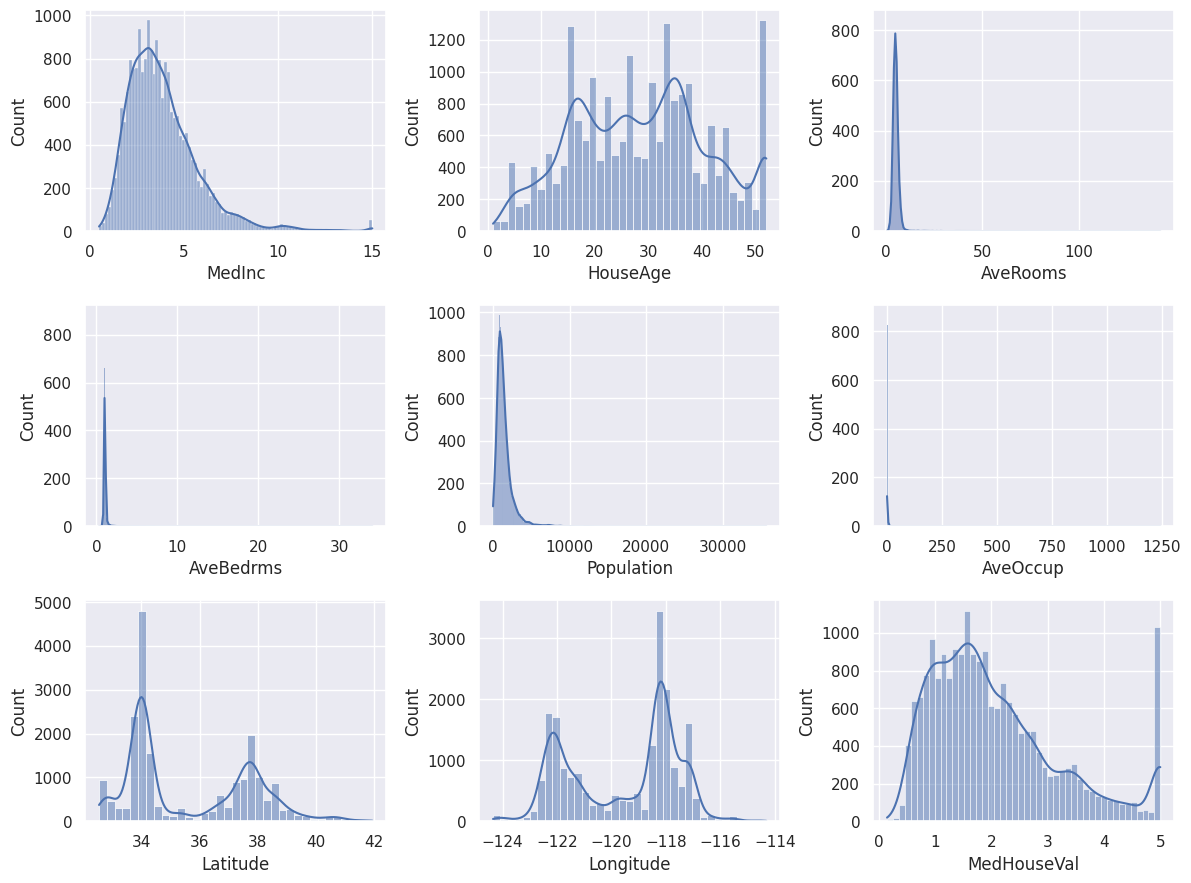

In [6]:
fig, axes = plt.subplots(figsize=(12,9), ncols=3, nrows=3)

for ax, col in zip(chain.from_iterable(axes), df.columns):
    sns.histplot(df, x=col, kde=True, ax=ax)

plt.tight_layout()

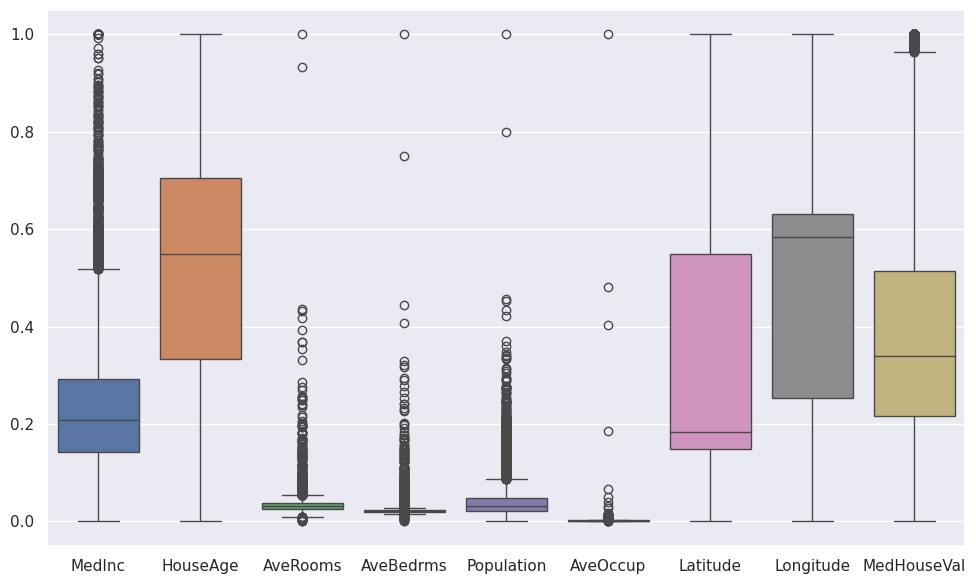

In [7]:
# observamos los boxplots porque parecen haber muchos outliers
fig, axes = plt.subplots(figsize=(10,6), ncols=1, nrows=1)

# escalamos para poder graficar todo en un mismo eje y
sns.boxplot((df - df.min(axis=0)) / (df.max(axis=0)-df.min(axis=0)))


plt.tight_layout()

* `AveRooms`, `AveBedrms`, `Population` y `AveOccup`tienen valores extremos muy alejados de la población general, se espera que esto influya negativamente en el ajuste de la regresión lineal por tener muy alta palanca.
* `Latitude` y `Longitude` aparentan ser bimodales.
* `MedHouseVal`, `HouseAge` y `MedInc` parecerían tener una masa _relativamente_ acampanada, aunque en los primeros dos casos hay átomos en el valor extremo (probablemente por truncamiento del valor medido original) y en el último hay una cola que si bien no es excesiva, es diferente de la de una normal.

En resumen, ninguna variable tiene una distribución visiblemente normal.

# 3) Regresión Lineal

In [8]:
# splits entre train y test
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

In [9]:
# estandarizacion simple
ss = StandardScaler()

X_train_std = ss.fit_transform(X_train)
X_test_std = ss.transform(X_test)

In [10]:
# ajuste de modelo
lr = LinearRegression(n_jobs=-1)

lr.fit(X_train_std, y_train)

LinearRegression(n_jobs=-1)

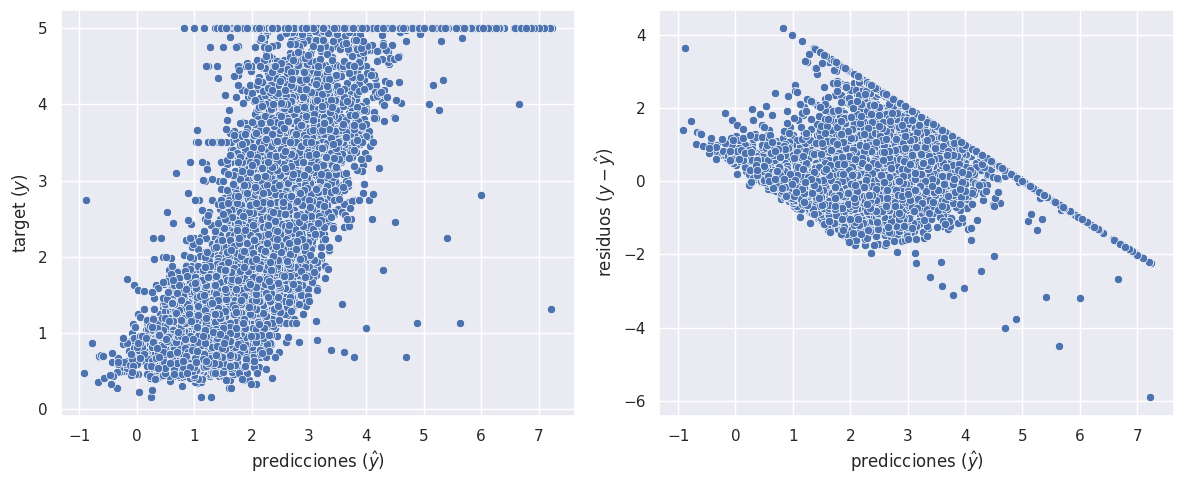

In [11]:
# gráfico de predicciones vs residuos y vs target
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(12,5))
y_pred_train = lr.predict(X_train_std)
res_train = y_train - y_pred_train

sns.scatterplot(x=y_pred_train, y=y_train,ax=ax1)
ax1.set_xlabel("predicciones ($\hat{y}$)")
ax1.set_ylabel("target ($y$)")

sns.scatterplot(x=y_pred_train, y=res_train,ax=ax2)
ax2.set_xlabel("predicciones ($\hat{y}$)")
ax2.set_ylabel("residuos ($y-\hat{y}$)")

plt.tight_layout()

In [12]:
# comparación de varianza explicada contra varianza del dataset
expl_var = ((y_pred_train-y_train.mean())**2).sum()
total_var = ((y_train-y_train.mean())**2).sum()
print("Varianza explicada:", expl_var)
print("Varianza total:", total_var)
print("R2:", (expl_var/total_var).round(4))

Varianza explicada: 11794.456461225018
Varianza total: 19355.92748251429
R2: 0.6093


Se considera que el ajuste es _razonable_, pero no es muy bueno. El comportamiento del target es capturado parcialmente, con problemas en los "extremos" de la población, especialmente con la componente truncada del target en 5.

# 4) Cálculo de métricas sobre test set

In [13]:
# utilidad
def test_model(model):
    y_pred = model.predict(X_test_std)

    fs = {
        'R2': r2_score, 
        'MAE': mean_absolute_error, 
        'MSE': mean_squared_error
    }

    return {name:f(y_test, y_pred) for name,f in fs.items()}        

In [14]:
pd.DataFrame([test_model(lr)], index=['LinReg'])

,R2,MAE,MSE
LinReg,0.59577,0.527247,0.530568


Los resultados se condicen con lo antes expuesto, el modelo aprende _algo_ pero está lejos de ser un modelo _bueno_.

# 5) Ridge

In [15]:
pip = make_pipeline(StandardScaler(), Ridge())

pip

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [16]:
gs = GridSearchCV(
    estimator=pip,
    param_grid={'ridge__alpha': np.linspace(0,12.5,200)},
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([ 0.        ,  0.06281407,  0.12562814,  0.18844221,  0.25125628,
        0.31407035,  0.37688442,  0.43969849,  0.50251256,  0.56532663,
        0.6281407 ,  0.69095477,  0.75376884,  0.81658291,  0.87939698,
        0.94221106,  1.00502513,  1.0678392 ,  1.13065327,  1.19346...
       10.67839196, 10.74120603, 10.8040201 , 10.86683417, 10.92964824,
       10.99246231, 11.05527638, 11.11809045, 11.18090452, 11.24371859,
       11.30653266, 11.36934673, 11.4321608 , 11.49497487, 11.55778894,
       11.62060302, 11.68341709, 11.74623116, 11.80904523, 11.8718593 ,
       11.93467337, 11.99748744, 12.06030151, 12.12311558, 12.18592965,
       12.24874372, 12.31155779, 12.37437186, 12.43718593, 12.5       ])},
             scoring='neg_mean_squared_error')

,ridge__alpha,kind,mean_MSE
0,0.0,min,0.526825
1,12.5,1se,0.526875


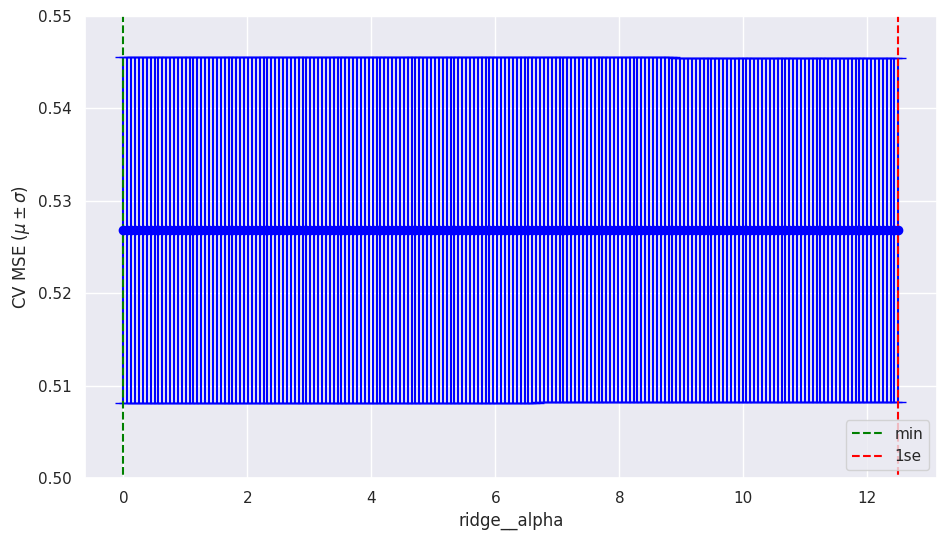

In [17]:
def plot_alpha_mse(gs: GridSearchCV, param_name: str, ax: plt.Axes) -> pd.DataFrame:
    param_vals = [elem[param_name] for elem in gs.cv_results_['params']]

    cv_score_mean = gs.cv_results_['mean_test_score'] * (-1) # neg MSE -> MSE
    cv_score_std = gs.cv_results_['std_test_score'] 

    ax.errorbar(param_vals, cv_score_mean, cv_score_std, color='blue', linestyle='', capsize=6, fmt='o')
    #ax.scatter(param_vals, cv_score_mean, color='blue')
    
    # tomamos el minimo
    idxmin = cv_score_mean.argmin()
    argmin = param_vals[idxmin]
    
    # 1se, aka max valor de regularizacion tal que está dentro de 1 stderr del mejor
    idx1se = (cv_score_mean < (cv_score_mean+cv_score_std)[idxmin]).argmin() - 1
    arg1se = param_vals[idx1se]

    for elem, name, color in (
        (argmin, 'min', 'green'),
        (arg1se, '1se', 'red')
    ):
        ax.vlines(elem, 0, 100, color=color, linestyle='dashed', label=name)
        
    ax.legend(loc='lower right')

    ax.set_xlabel(param_name)
    ax.set_ylabel('CV MSE ($\mu \pm \sigma$)')

    # armamos el dataframe de valores
    return pd.DataFrame({
        param_name: [argmin, arg1se], 
        'kind':['min','1se'], 
        'mean_MSE': cv_score_mean[[idxmin, idx1se]]})
    
fig, ax = plt.subplots(figsize=(11,6))
res_df = plot_alpha_mse(gs, 'ridge__alpha', ax)
display(res_df)
ax.set_ylim(0.5,0.55)
plt.show()

Resulta interesante que todos los valores de $\alpha$ parecen tener virtualmente el mismo efecto, i.e. regularizar no aporta nada (entendible dado no overfitting de modelo lineal). Probamos utilizando el set ya estandarizado.

In [18]:
gs2 = GridSearchCV(
    estimator=Ridge(),
    param_grid={'alpha': np.linspace(0,12.5,200)},
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5
)

gs2.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([ 0.        ,  0.06281407,  0.12562814,  0.18844221,  0.25125628,
        0.31407035,  0.37688442,  0.43969849,  0.50251256,  0.56532663,
        0.6281407 ,  0.69095477,  0.75376884,  0.81658291,  0.87939698,
        0.94221106,  1.00502513,  1.0678392 ,  1.13065327,  1.19346734,
        1.25628141,  1.31909548,  1.38190955,  1.44472362,  1.50753769,
        1.57035176,  1...
       10.67839196, 10.74120603, 10.8040201 , 10.86683417, 10.92964824,
       10.99246231, 11.05527638, 11.11809045, 11.18090452, 11.24371859,
       11.30653266, 11.36934673, 11.4321608 , 11.49497487, 11.55778894,
       11.62060302, 11.68341709, 11.74623116, 11.80904523, 11.8718593 ,
       11.93467337, 11.99748744, 12.06030151, 12.12311558, 12.18592965,
       12.24874372, 12.31155779, 12.37437186, 12.43718593, 12.5       ])},
             scoring='neg_mean_squared_error')

,alpha,kind,mean_MSE
0,6.532663,min,0.526818
1,12.500000,1se,0.526824


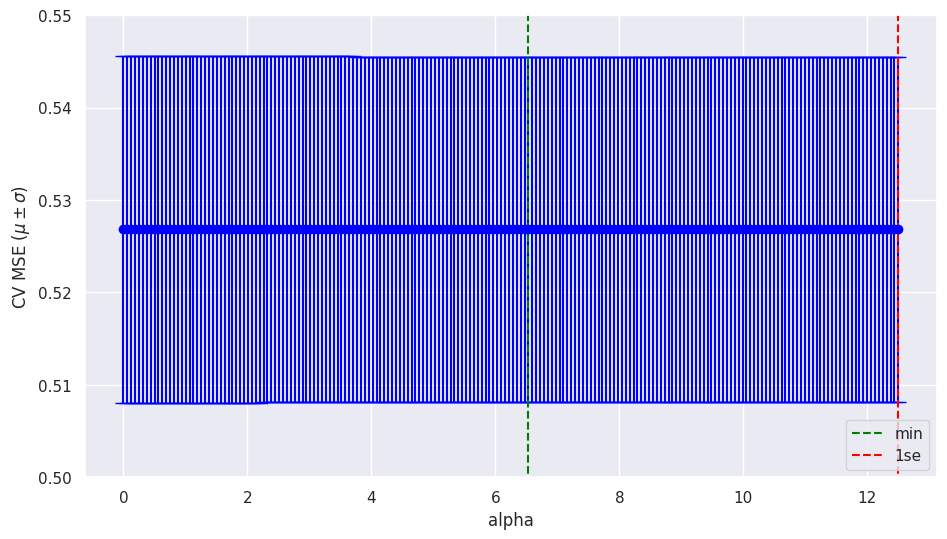

In [19]:
fig, ax = plt.subplots(figsize=(11,6))
res_df = plot_alpha_mse(gs2, 'alpha', ax)

display(res_df)

ax.set_ylim(0.5,0.55)
plt.show()

Nuevamente observamos esta indiferencia respecto del parámetro, aunque en este caso el MSE es levemente menor y el óptimo no está en 0.

# 6) Comparación entre modelos

Considando a la mejor versión de Ridge como la de $\alpha \approx 6.532663$, se predice sobre test.

In [20]:
# tomamos mejor estimador de gridsearch2
ridge = gs2.best_estimator_
ridge

Ridge(alpha=6.532663316582914)

In [21]:
res = [{'model':name, **test_model(model)} for name, model in [('linear', lr),('ridge', ridge)]]

pd.DataFrame(res).set_index('model')

,R2,MAE,MSE
model,,,
linear,0.595770,0.527247,0.530568
ridge,0.595886,0.527222,0.530416


Los dos modelos no son significativamente diferentes. Dado que el modelo lineal de base no presentaba overfitting y era estable en la varianza explicada (con valores de $R^2$ casi iguales entre train y test) era esperable que agregar regularización no mejore la performance.
En términos estrictos, Ridge da resultados ínfimamente mejores (alrededor de la 4º-5º cifra significativa), tanto en MAE como en MSE. Esta diferencia mínima es la apreciable entre el valor de $\alpha=0$ y el óptimo en el último gráfico.